# Implementation and optimization of the mean-timer technique in drift tube detectors

### Students: Barone Francesco Pio, Nagaro Gianmarco, Ninni Daniele, Valentini Lorenzo

## PART 2: MEAN-TIMER TECHNIQUE

$$
T_{max} = \frac{(t_1-t_0) + (t_3 - t_0)}{2} + (t_2 - t_0)   \iff   t_0^{123} = \frac{t_1 + 2t_2 + t_3 - 2T_{max}}{4}
$$

$$
T_{max} = \frac{3(t_2-t_0)}{2} + t_1 - \frac{(t_4 - t_0)}{2}   \iff   t_0^{124} = \frac{2t_1 + 3t_2 - t_4 - 2T_{max}}{4}
$$

$$
T_{max} = \frac{3(t_3-t_0)}{2} + t_4 - \frac{(t_1 - t_0)}{2}   \iff   t_0^{134} = \frac{-t_1 + 3t_3 + 2t_4 - 2T_{max}}{4}
$$

$$
T_{max} = \frac{(t_2-t_0) + (t_4 - t_0)}{2} + (t_3 - t_0)   \iff   t_0^{234} = \frac{t_2 + 2t_3 + t_4 - 2T_{max}}{4}
$$

$$
t_0^{1234} = \frac{t_0^{123} + t_0^{124} + t_0^{134} + t_0^{234}}{4} = \frac{t_1 + 3t_2 + 3t_3 + t_4 - 4T_{max}}{8}
$$

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotters import plot_event
from plotters import plot_event_from_dataframe

In [ ]:
# load the dataset containing the events identified in PART 1
source_file = '/home/lab/dat/262_000_definitive.txt'
events = pd.read_csv(source_file, sep=",")
events['LAYERS'] = events['LAYERS'].astype(str)
for i in range(1, 5):
    events['L'+str(i)+'_HIT'] = events['L'+str(i)+'_HIT'].astype('Int64')
    events['L'+str(i)+'_CELL'] = events['L'+str(i)+'_CELL'].astype('Int64')
events

,L1_HIT,L1_TIME,L1_CELL,L2_HIT,L2_TIME,L2_CELL,L3_HIT,L3_TIME,L3_CELL,L4_HIT,L4_TIME,L4_CELL,LAYERS
0,47,1.915090e+07,0,49,1.915103e+07,0,45,1.915083e+07,0,48,1.915104e+07,0,1234
1,5076,2.207774e+09,0,5074,2.207774e+09,0,5075,2.207774e+09,0,5072,2.207774e+09,0,1234
2,5977,2.616131e+09,0,5975,2.616131e+09,0,<NA>,NaN,<NA>,5976,2.616131e+09,0,124
3,<NA>,NaN,<NA>,8354,3.655548e+09,0,8356,3.655548e+09,0,8355,3.655548e+09,0,234
4,8595,3.765115e+09,0,8596,3.765115e+09,0,<NA>,NaN,<NA>,8597,3.765116e+09,0,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56918,1293774,5.214760e+11,15,1293778,5.214760e+11,15,1293777,5.214760e+11,15,1293776,5.214760e+11,15,1234
56919,1293883,5.215221e+11,15,<NA>,NaN,<NA>,1293882,5.215221e+11,15,1293884,5.215221e+11,15,134
56920,1294986,5.220509e+11,15,1294988,5.220509e+11,15,1294990,5.220509e+11,15,1294987,5.220509e+11,15,1234
56921,1296029,5.225016e+11,15,1296026,5.225016e+11,15,1296028,5.225016e+11,15,1296025,5.225016e+11,15,1234


In [ ]:
# define the function that computes the crossing angle
#         ti : time recorded by the i-th layer's cell
#         tj : time recorded by the (i+2)-th layer's cell
#    v_drift : drift velocity
#          h : height of each cell
# angle_sign : sign of the crossing angle (deduced by applying the mean-timer technique)
def crossing_angle(ti, tj, v_drift, h, angle_sign):
    
    dx = np.abs(v_drift * (ti-tj))   # projection of the distance between the two hits along the direction of the layers
    angle_tan = dx / (2*h)   # tangent of the crossing angle
    angle = angle_sign * np.rad2deg(np.arctan(angle_tan))
    
    return angle

# define the functions that apply the mean-timer technique to the dataset containing the events
#    tmax : maximum drift time
# v_drift : drift velocity
#       h : height of each cell
def meantimer_123(dataframe, tmax, v_drift, h):   # case layers 1-2-3
    
    df = dataframe.copy()
    t1, t2, t3 = df['L1_TIME'], df['L2_TIME'], df['L3_TIME']
    c1, c2, c3 = df['L1_CELL'], df['L2_CELL'], df['L3_CELL']
    
    df['PEDESTAL'] = (t1 + 2*t2 + t3 - 2*tmax) / 4
    
    mask = (c2 == c1)
    
    df.loc[mask, 'PATTERN'] = 'LRL_'
    df.loc[mask, 'ANGLE'] = crossing_angle(t1, t3, v_drift, h, np.sign(t1-t3))
    
    df.loc[~mask, 'PATTERN'] = 'RLR_'
    df.loc[~mask, 'ANGLE'] = crossing_angle(t1, t3, v_drift, h, np.sign(t3-t1))
    
    return df

def meantimer_124(dataframe, tmax, v_drift, h):   # case layers 1-2-4
    
    df = dataframe.copy()
    t1, t2, t4 = df['L1_TIME'], df['L2_TIME'], df['L4_TIME']
    c1, c2, c4 = df['L1_CELL'], df['L2_CELL'], df['L4_CELL']
    
    df['PEDESTAL'] = (2*t1 + 3*t2 - t4 -2*tmax) / 4
    
    mask = (c2 == c1)
    
    df.loc[mask, 'PATTERN'] = 'LR_R'
    df.loc[mask, 'ANGLE'] = crossing_angle(t2, t4, v_drift, h, np.sign(t4-t2))
    
    df.loc[~mask, 'PATTERN'] = 'RL_L'
    df.loc[~mask, 'ANGLE'] = crossing_angle(t2, t4, v_drift, h, np.sign(t2-t4))
    
    return df

def meantimer_134(dataframe, tmax, v_drift, h):   # case layers 1-3-4
    
    df = dataframe.copy()
    t1, t3, t4 = df['L1_TIME'], df['L3_TIME'], df['L4_TIME']
    c1, c3, c4 = df['L1_CELL'], df['L3_CELL'], df['L4_CELL']
    
    df['PEDESTAL'] = (-t1 + 3*t3 + 2*t4 -2*tmax) / 4
    
    mask = (c4 == c1)
    
    df.loc[mask, 'PATTERN'] = 'L_LR'
    df.loc[mask, 'ANGLE'] = crossing_angle(t1, t3, v_drift, h, np.sign(t1-t3))
    
    df.loc[~mask, 'PATTERN'] = 'R_RL'
    df.loc[~mask, 'ANGLE'] = crossing_angle(t1, t3, v_drift, h, np.sign(t3-t1))
    
    return df

def meantimer_234(dataframe, tmax, v_drift, h):   # case layers 2-3-4
    
    df = dataframe.copy()
    t2, t3, t4 = df['L2_TIME'], df['L3_TIME'], df['L4_TIME']
    c2, c3, c4 = df['L2_CELL'], df['L3_CELL'], df['L4_CELL']
    
    df['PEDESTAL'] = (t2 + 2*t3 + t4 -2*tmax) / 4
    
    mask = (c3 == c2)
    
    df.loc[mask, 'PATTERN'] = '_RLR'
    df.loc[mask, 'ANGLE'] = crossing_angle(t2, t4, v_drift, h, np.sign(t4-t2))
    
    df.loc[~mask, 'PATTERN'] = '_LRL'
    df.loc[~mask, 'ANGLE'] = crossing_angle(t2, t4, v_drift, h, np.sign(t2-t4))
    
    return df
 
def meantimer_1234(dataframe, tmax, v_drift, h):   # case layers 1-2-3-4
    
    df = dataframe.copy()
    t1, t2, t3, t4 = df['L1_TIME'], df['L2_TIME'], df['L3_TIME'], df['L4_TIME']
    c1, c2, c3, c4 = df['L1_CELL'], df['L2_CELL'], df['L3_CELL'], df['L4_CELL']
    
    df['PEDESTAL'] = (t1 + 3*t2 + 3*t3 + t4 - 4*tmax) / 8
    
    mask = (c4 == c1)
    angles_tol = 5   # tolerance (deg) on the differences between [crossing angles computed using layers 1-3] and [crossing angles computed using layers 2-4]
    
    df.loc[mask, 'PATTERN'] = 'LRLR'
    angles_13 = crossing_angle(t1, t3, v_drift, h, np.sign(t1-t3))
    angles_24 = crossing_angle(t2, t4, v_drift, h, np.sign(t4-t2))
    d_angles = np.abs(angles_13 - angles_24)
    angles_mask = (d_angles < angles_tol)
    df.loc[mask & angles_mask, 'ANGLE'] = ((angles_13 + angles_24) / 2)
    df.loc[mask & ~angles_mask, 'ANGLE'] = 'FAIL'
    
    df.loc[~mask, 'PATTERN'] = 'RLRL'
    angles_13 = crossing_angle(t1, t3, v_drift, h, np.sign(t3-t1))
    angles_24 = crossing_angle(t2, t4, v_drift, h, np.sign(t2-t4))
    d_angles = np.abs(angles_13 - angles_24)
    angles_mask = (d_angles < angles_tol)
    df.loc[~mask & angles_mask, 'ANGLE'] = ((angles_13 + angles_24) / 2)
    df.loc[~mask & ~angles_mask, 'ANGLE'] = 'FAIL'

    return df
    
def meantimer(dataframe):
    
    df = dataframe.copy()
    
    # dictionary used to select the appropriate function
    meantimers = {'123'  : meantimer_123,
                  '124'  : meantimer_124,
                  '134'  : meantimer_134,
                  '234'  : meantimer_234,
                  '1234' : meantimer_1234}

    # dictionary used to convert the pattern of the trajectory into signs of the positions in the cells
    LR_to_sign = {'L' : -1,
                  'R' : +1,
                  '_' : 0}
    
    # detector parameters
    tmax = 390   # maximum drift time (ns)
    L = 42   # length of each cell (mm)
    h = 13   # height of each cell (mm)
    v_drift = L / (2*tmax)   # drift velocity (mm/ns)
    
    # apply the mean-timer functions to the dataset
    df['PEDESTAL'] = pd.Series(dtype='float')
    df['PATTERN'] = pd.Series(dtype='str')
    df['ANGLE'] = pd.Series(dtype='float')
    
    for i in meantimers:
        mask = (df['LAYERS'] == i)
        df[mask] = (meantimers[i])(df[mask], tmax, v_drift, h)
        
    df = df[df['ANGLE'] != 'FAIL']   # reject 4-hits events for which it is not possible to compute the crossing angle properly
    
    for i in range(1, 5):
        df['L'+str(i)+'_DRIFT'] = df['L'+str(i)+'_TIME'] - df['PEDESTAL']
        df = df[((df['L'+str(i)+'_DRIFT'] < tmax) & (df['L'+str(i)+'_DRIFT'] > 0)) | (np.isnan(df['L'+str(i)+'_DRIFT']))]   # reject events with drift times >= 'tmax' or <= 0
        df['L'+str(i)+'_X'] = v_drift * df['L'+str(i)+'_DRIFT'] * (df['PATTERN'].str[i-1]).replace(LR_to_sign)
    
    df = df.reset_index(drop=True)
    
    return df

%timeit meantimer(events)

341 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
events = meantimer(events)
events[['PEDESTAL', 'PATTERN', 'ANGLE', 'L1_DRIFT', 'L1_X', 'L2_DRIFT', 'L2_X', 'L3_DRIFT', 'L3_X', 'L4_DRIFT', 'L4_X']]
#events

,PEDESTAL,PATTERN,ANGLE,L1_DRIFT,L1_X,L2_DRIFT,L2_X,L3_DRIFT,L3_X,L4_DRIFT,L4_X
0,2.207773e+09,LRLR,-8.9732,166.562500,-8.968750,189.062500,10.180288,239.062500,-12.872596,109.062500,5.872596
1,3.655548e+09,_RLR,20.5313,NaN,NaN,22.708333,1.222756,276.875000,-14.908654,203.541667,10.959936
2,4.305668e+09,_RLR,22.668,NaN,NaN,22.500000,1.211538,266.666667,-14.358974,224.166667,12.070513
3,5.527147e+09,_RLR,12.457,NaN,NaN,55.416666,2.983974,281.250000,-15.144231,162.083333,8.727564
4,8.472991e+09,LR_R,10.367,275.833333,-14.852564,158.333333,8.525641,NaN,NaN,246.666666,13.282051
...,...,...,...,...,...,...,...,...,...,...,...
49130,5.184916e+11,LRLR,1.3834,243.750000,-13.125000,162.916687,8.772437,221.250000,-11.913462,163.750000,8.817308
49131,5.186522e+11,LRLR,2.22338,351.145813,-18.907851,54.479126,2.933491,326.145813,-17.561698,66.979126,3.606568
49132,5.214760e+11,LRLR,-13.6764,20.625000,-1.110577,308.125000,16.591346,140.625000,-7.572115,193.125000,10.399038
49133,5.215221e+11,L_LR,25.4699,366.666626,-19.743588,NaN,NaN,136.666626,-7.358972,368.333313,19.833332


In [ ]:
# write the DataFrame 'events' to a csv file
output_file = '/home/lab/dat/262_000_full_elab.txt'
events.to_csv(output_file, index=False)

In [ ]:
# load the DataFrame 'events' from file
events = pd.read_csv(output_file, sep=",")

## EXAMPLES

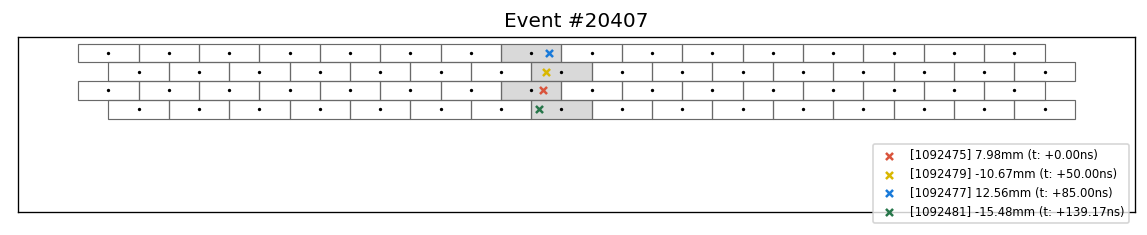

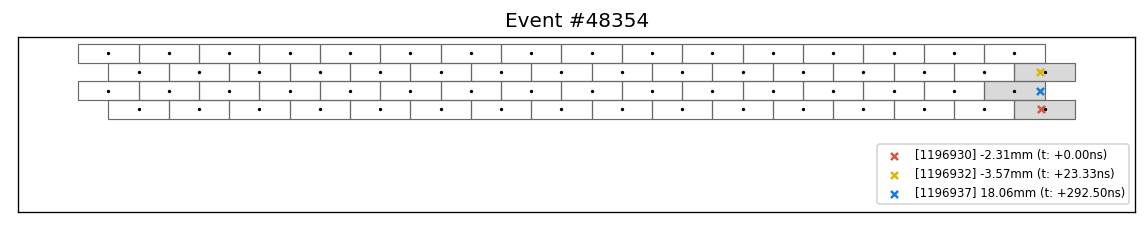

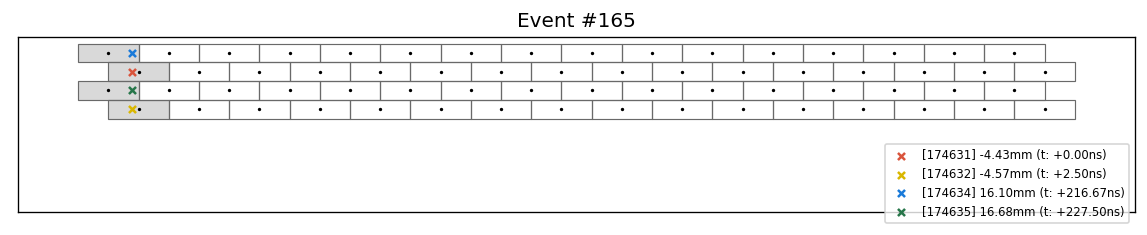

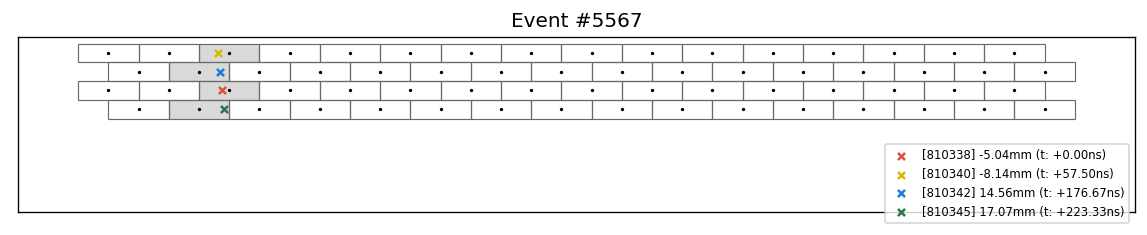

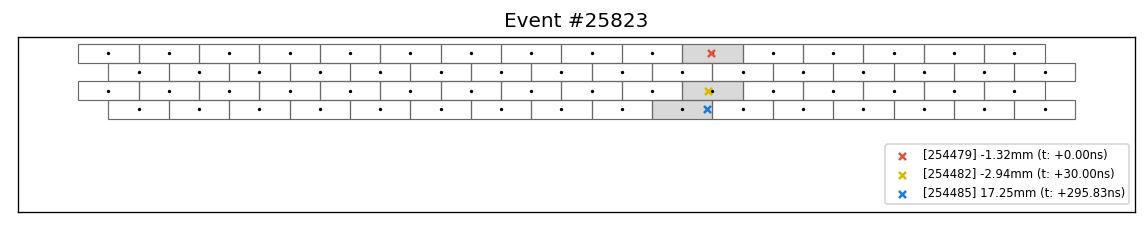

In [ ]:
# plot 5 random events
for i in range(5):
    j = npr.randint(0, len(events))
    plot_event_from_dataframe(events, index=j, title=f'Event #{j}', focus_area=False)

## DRIFT TIMES DISTRIBUTION (expected: uniform between 0 and tmax)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22, 11))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        layer = str(i+2*j+1)
        plot = sns.histplot(data=events, x='L'+layer+'_DRIFT', hue='LAYERS', stat='count', bins=40, kde=True, palette='Set1', ax=ax[i][j])
        plot.set(title='LAYER '+layer+' - DRIFT TIMES', xlabel='drift time $(ns)$', ylabel='count')

## CROSSING ANGLES DISTRIBUTION (expected: narrow gaussian with mean 0)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
plot = sns.histplot(data=events, x='ANGLE', hue='LAYERS', stat='count', bins=80, kde=True, palette='Set1', ax=ax)
plot.set(title='CROSSING ANGLES', xlabel='crossing angle $(deg)$', ylabel='count')
plt.show()

## PART 3: OLD CODES

### 1) EVENT DETECTION (DANIELE)

```python
def find_events(data):
    
    # find candidates corresponding to the 'left' configuration
    print('Finding candidates corresponding to the "left" configuration ...')
    left_size = data.groupby(['ORBIT_CNT', 'tile']).size().to_frame('size')
    left = data.join(left_size, on=['ORBIT_CNT', 'tile'])
    data_reduced = left[~left['size'].between(3, 4)].drop('size', 1)
    left = left[left['size'].between(3, 4)]
    left['event_id'] = left['ORBIT_CNT'].astype(str) + '_' + left['tile'].astype(str) + '_L'

    # find candidates corresponding to the 'right' configuration
    print('Finding candidates corresponding to the "right" configuration ...')
    data_reduced.loc[data_reduced['layer'].isin([1, 3]), 'tile'] += 1
    right_size = data_reduced.groupby(['ORBIT_CNT', 'tile']).size().to_frame('size')
    right = data_reduced.join(right_size, on=['ORBIT_CNT', 'tile'])
    right = right[right['size'].between(3, 4)]
    right['event_id'] = right['ORBIT_CNT'].astype(str) + '_' + right['tile'].astype(str) + '_R'
    right.loc[data_reduced['layer'].isin([1, 3]), 'tile'] -= 1
   
    # build dataframe of events
    print('Building dataframe of events ...')
    events = pd.concat([left, right], ignore_index=True, sort=False)
    events = events.groupby('event_id').agg(list).reset_index()
    
    return events
```

### 2) MEAN-TIMER (DANIELE) -> takes about 80 seconds for each dataset

```python
# define the function that computes the crossing angle
#         ti : time recorded by the i-th layer's cell
#         tj : time recorded by the (i+2)-th layer's cell
#    v_drift : drift velocity
#          h : height of each cell
# angle_sign : sign of the crossing angle (deduced by applying the mean-timer technique)
def crossing_angle(ti, tj, v_drift, h, angle_sign):
    dx = np.abs(v_drift * (ti-tj))   # projection of the distance between the two hits along the direction of the layers
    angle_tan = dx / (2*h)   # tangent of the crossing angle
    angle = angle_sign * np.rad2deg(np.arctan(angle_tan))
    return angle

# define the functions that apply the mean-timer technique to the single event
#       t : list of times recorded by the cells hit by the particle
#       c : list of indices of the cells hit by the particle
#    tmax : maximum drift time
# v_drift : drift velocity
#       h : height of each cell
def meantimer_123(t, c, tmax, v_drift, h):   # case layers 1-2-3
    t1, t2, t3, t4 = t
    c1, c2, c3, c4 = c
    t0 = (t1 + 2*t2 + t3 - 2*tmax) / 4   # time pedestal
    if c2 == c1:
        pattern = 'LRL_'
        angle_sign = np.sign(t1-t3)   
    else:
        pattern = 'RLR_'
        angle_sign = np.sign(t3-t1)
    angle = crossing_angle(t1, t3, v_drift, h, angle_sign)
    return t0, pattern, angle

def meantimer_124(t, c, tmax, v_drift, h):   # case layers 1-2-4
    t1, t2, t3, t4 = t
    c1, c2, c3, c4 = c
    t0 = (2*t1 + 3*t2 - t4 -2*tmax) / 4   # time pedestal
    if c2 == c1:
        pattern = 'LR_R'
        angle_sign = np.sign(t4-t2)   
    else:
        pattern = 'RL_L'
        angle_sign = np.sign(t2-t4)  
    angle = crossing_angle(t2, t4, v_drift, h, angle_sign)
    return t0, pattern, angle

def meantimer_134(t, c, tmax, v_drift, h):   # case layers 1-3-4
    t1, t2, t3, t4 = t
    c1, c2, c3, c4 = c
    t0 = (-t1 + 3*t3 + 2*t4 -2*tmax) / 4   # time pedestal
    if c4 == c1:
        pattern = 'L_LR'
        angle_sign = np.sign(t1-t3)
    else:
        pattern = 'R_RL'
        angle_sign = np.sign(t3-t1)
    angle = crossing_angle(t1, t3, v_drift, h, angle_sign)
    return t0, pattern, angle

def meantimer_234(t, c, tmax, v_drift, h):   # case layers 2-3-4
    t1, t2, t3, t4 = t
    c1, c2, c3, c4 = c
    t0 = (t2 + 2*t3 + t4 -2*tmax) / 4   # time pedestal
    if c3 == c2:
        pattern = '_RLR'
        angle_sign = np.sign(t4-t2)
    else:
        pattern = '_LRL'
        angle_sign = np.sign(t2-t4)
    angle = crossing_angle(t2, t4, v_drift, h, angle_sign)
    return t0, pattern, angle
    
def meantimer_1234(t, c, tmax, v_drift, h):   # case layers 1-2-3-4
    t0_123, pattern_123, angle_123 = meantimer_123(t, c, tmax, v_drift, h)
    t0_124, pattern_124, angle_124 = meantimer_124(t, c, tmax, v_drift, h)
    t0_134, pattern_134, angle_134 = meantimer_134(t, c, tmax, v_drift, h)
    t0_234, pattern_234, angle_234 = meantimer_234(t, c, tmax, v_drift, h)
    
    pedestals, angles = [], []   # lists of plausible time pedestals and crossing angles
    pattern = ''
    sampling = 25   # sampling period of the acquisition system (ns)
    
    # case layers 1-2-3 + layers 1-2-4
    if np.abs(t0_123 - t0_124) < sampling:
        pedestals += [t0_123, t0_124]
        angles += [angle_123, angle_124]
        if pattern == '':
            pattern = pattern_123[:-1] + pattern_124[-1]
    
    # case layers 1-2-3 + layers 1-3-4
    if np.abs(t0_123 - t0_134) < sampling:
        pedestals += [t0_123, t0_134]
        angles += [angle_123, angle_134]
        if pattern == '':
            pattern = pattern_123[:2] + pattern_134[2:]
    
    # case layers 1-2-3 + layers 2-3-4
    if np.abs(t0_123 - t0_234) < sampling:
        pedestals += [t0_123, t0_234]
        angles += [angle_123, angle_234]
        if pattern == '':
            pattern = pattern_123[:2] + pattern_234[2:]
    
    # case layers 1-2-4 + layers 1-3-4
    if np.abs(t0_124 - t0_134) < sampling:
        pedestals += [t0_124, t0_134]
        angles += [angle_124, angle_134]
        if pattern == '':
            pattern = pattern_124[:2] + pattern_134[2:]
    
    # case layers 1-2-4 + layers 2-3-4
    if np.abs(t0_124 - t0_234) < sampling:
        pedestals += [t0_124, t0_234]
        angles += [angle_124, angle_234]
        if pattern == '':
            pattern = pattern_124[:2] + pattern_234[2:]
    
    # case layers 1-3-4 + layers 2-3-4
    if np.abs(t0_134 - t0_234) < sampling:
        pedestals += [t0_134, t0_234]
        angles += [angle_134, angle_234]
        if pattern == '':
            pattern = pattern_134[0] + pattern_234[1:]
    
    if len(pedestals) == 0:
        return 0, 'FAIL', 0
    else:
        t0, angle = np.mean(pedestals), np.mean(angles)
        return t0, pattern, angle

# define the function that applies the mean-timer technique to the dataset containing the events
def meantimer(dataframe):
    df = dataframe.copy()
    
    # dictionary used to select the appropriate function
    meantimers = {'123'  : meantimer_123,
                  '124'  : meantimer_124,
                  '134'  : meantimer_134,
                  '234'  : meantimer_234,
                  '1234' : meantimer_1234}

    # dictionary used to convert the pattern of the trajectory into signs of the positions in the cells
    LR_to_sign = {'L' : -1,
                  'R' : +1,
                  '_' : 0}
    
    # detector parameters
    tmax = 390   # maximum drift time (ns)
    L = 42   # length of each cell (mm)
    h = 13   # height of each cell (mm)
    v_drift = L / (2*tmax)   # drift velocity (mm/ns)
    
    # apply the mean-timer functions to the dataset
    df[['PEDESTAL', 'PATTERN', 'ANGLE']] = df.apply(lambda row: meantimers[row['LAYERS']](row[['L1_TIME', 'L2_TIME', 'L3_TIME', 'L4_TIME']],
                                                                                          row[['L1_CELL', 'L2_CELL', 'L3_CELL', 'L4_CELL']],
                                                                                          tmax, v_drift, h), axis=1, result_type="expand")
    df = df[df['PATTERN'] != 'FAIL']   # reject 4-hits events for which it is not possible to compute the time pedestal properly
    for i in range(1, 5):
        df['L'+str(i)+'_DRIFT'] = np.abs(df['L'+str(i)+'_TIME'] - df['PEDESTAL'])
        df = df[(df['L'+str(i)+'_DRIFT'] < tmax) | (np.isnan(df['L'+str(i)+'_DRIFT']))]   # reject events with drift times >= 'tmax'
        df['L'+str(i)+'_X'] = v_drift * df['L'+str(i)+'_DRIFT'] * (df['PATTERN'].str[i-1]).replace(LR_to_sign)
    
    df = df.reset_index(drop=True)
    return df
```

### 3) VECTORIZED 4-LAYERS MEAN-TIMER v1 (DANIELE)

```python
def meantimer_1234(dataframe, tmax, v_drift, h):   # case layers 1-2-3-4
    df = dataframe.copy()
    temp = meantimer_123(df, tmax, v_drift, h)
    temp.rename(columns={'PEDESTAL':'PEDESTAL_123', 'PATTERN':'PATTERN_123', 'ANGLE':'ANGLE_123'}, inplace=True)
    temp = meantimer_124(temp, tmax, v_drift, h)
    temp.rename(columns={'PEDESTAL':'PEDESTAL_124', 'PATTERN':'PATTERN_124', 'ANGLE':'ANGLE_124'}, inplace=True)
    temp = meantimer_134(temp, tmax, v_drift, h)
    temp.rename(columns={'PEDESTAL':'PEDESTAL_134', 'PATTERN':'PATTERN_134', 'ANGLE':'ANGLE_134'}, inplace=True)
    temp = meantimer_234(temp, tmax, v_drift, h)
    temp.rename(columns={'PEDESTAL':'PEDESTAL_234', 'PATTERN':'PATTERN_234', 'ANGLE':'ANGLE_234'}, inplace=True)
    df['PEDESTAL'] = (temp['PEDESTAL_123'] + temp['PEDESTAL_124'] + temp['PEDESTAL_134'] + temp['PEDESTAL_234']) / 4
    df['ANGLE'] = (temp['ANGLE_123'] + temp['ANGLE_124'] + temp['ANGLE_134'] + temp['ANGLE_234']) / 4
    df['PATTERN'] = temp['PATTERN_123'].str[:2] + temp['PATTERN_234'].str[2:]
    return df
```

### 4) VECTORIZED 4-LAYERS MEAN-TIMER v2 (DANIELE)

```python
def meantimer_1234(dataframe, tmax, v_drift, h):   # case layers 1-2-3-4
    
    df = dataframe.copy()
    t1, t2, t3, t4 = df['L1_TIME'], df['L2_TIME'], df['L3_TIME'], df['L4_TIME']
    c1, c2, c3, c4 = df['L1_CELL'], df['L2_CELL'], df['L3_CELL'], df['L4_CELL']
    
    df['PEDESTAL'] = (t1 + 3*t2 + 3*t3 + t4 - 4*tmax) / 8
    
    mask = (c4 == c1)
    
    df.loc[mask, 'PATTERN'] = 'LRLR'
    df.loc[mask, 'ANGLE'] = (crossing_angle(t1, t3, v_drift, h, np.sign(t1-t3)) + crossing_angle(t2, t4, v_drift, h, np.sign(t4-t2))) / 2
    
    df.loc[~mask, 'PATTERN'] = 'RLRL'
    df.loc[~mask, 'ANGLE'] = (crossing_angle(t1, t3, v_drift, h, np.sign(t3-t1)) + crossing_angle(t2, t4, v_drift, h, np.sign(t2-t4))) / 2
    
    return df
```